In [1]:
import sys
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../../../NN_prior/")
from custom_mean import LinearCalibration

In [2]:
data_dir = "data/"
output_dir = "output_files/"
model_dir = "../lcls_cu_injector_nn_model/"

## Load Normalized Calibration Data

In [3]:
x_n = torch.load(data_dir + "normalized_calibration_inputs.pt")
y_n = torch.load(data_dir + "normalized_calibration_outputs.pt")
x_n.shape, y_n.shape

(torch.Size([834, 16]), torch.Size([834, 5]))

## Load LUME-Model

In [4]:
# create base model
base_model = torch.load(model_dir + "model/model.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_dir + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_dir + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_dir + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_dir + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_dir + "model/pv_variables.yml"))

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_dir + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs[:2],
)

## Load Trained Model with Calibration Layers

In [5]:
batch_size = 10
reg = 1e-4
lr = 1e-5
start_file_name = "continue6_{}_bs={:d}_reg={:.0e}_lr={:.0e}_n={:d}k".format("mae", batch_size, reg, lr, int(1e2))
cal_model = torch.load(output_dir + start_file_name + "_model.pt")
cal_model

LinearCalibration(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=300, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=True)
    (12): ELU(alpha=1.0)
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=200, bias=True)
    (15): ELU(alpha=1.0)
    (16): Dropout(p=0.05, inplace=False)
    (17): Linear(in_features=200, out_features=100, bias=True)
    (18): ELU(alpha=1.0)
    (19): Dropout(p=0.05, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ELU(alpha=1.0)
    (22): Linear(in

In [6]:
# deactivate gradients in base model and put in eval mode
cal_model.model.requires_grad_(False)
cal_model.model.eval()
cal_model.model.training

False

In [7]:
# define trainable parameters
trainable_params = []
for name, param in cal_model.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params.append(getattr(cal_model, name))

raw_y_scale
raw_y_shift
raw_x_scale
raw_x_shift


In [8]:
# initial parameter values
for name, param in cal_model.named_parameters():
    if param.requires_grad and name.startswith("raw_"):
        print(f"{name[4:]}: ", getattr(cal_model, name[4:]).data)

y_scale:  tensor([4.3467, 3.9626, 0.6931, 0.6931, 0.6931])
y_shift:  tensor([-0.0186, -0.0166,  0.0000,  0.0000,  0.0000])
x_scale:  tensor([0.9187, 0.8737, 0.7396, 1.1941, 0.4890, 0.1711, 0.7801, 0.7677, 0.8132,
        0.7016, 1.3571, 1.0272, 0.4612, 0.8795, 0.8294, 0.5634])
x_shift:  tensor([ 0.3353,  0.6092,  0.2267,  0.0263,  0.6716,  2.5014,  0.3033, -0.7061,
         0.4053, -1.0232, -0.1624,  0.1658,  1.1450, -0.0414,  0.0836,  0.8769])


## Train Calibration Layers

In [9]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [10]:
# define dataloader
pin_memory = True
trainset = Dataset(x_n, y_n)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=0, pin_memory=pin_memory)

In [11]:
# training configuration
reg = 1e-4
lr = 1e-5
n_epochs = int(1e5)
optimizer = torch.optim.Adam(trainable_params, lr=lr, weight_decay=reg)
# criterion = torch.nn.MSELoss(reduction="sum")
criterion = torch.nn.L1Loss(reduction="sum")

In [12]:
# training loop
train_losses, full_losses = [], []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "FULL_LOSS", "ETA"))
t0 = time.time()
best_loss = float("inf")

for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
        inputs, labels = batch_data
        optimizer.zero_grad()
        outputs = cal_model(inputs)
        loss = criterion(outputs[:, :2], labels[:, :2])  # use only transverse beam size
        loss.backward()
        optimizer.step()
        if i == 0:
            # store loss
            train_losses.append(loss.item())
            full_outputs = cal_model(x_n)
            full_loss = criterion(full_outputs[:, :2], y_n[:, :2])
            full_losses.append(full_loss.item())
            # print info
            if epoch % (n_epochs // 10) == 0:
                t_avg = (time.time() - t0) / (epoch + 1)
                t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
                if t_r <= 1.0:
                    t_info = "{:.2f} sec".format(60 * t_r)
                else:
                    t_info = "{:.2f} min".format(t_r)
                info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch, loss, full_loss, t_info)
                if full_loss < best_loss:
                    info = "\033[0;32m" + info + '\x1b[0m'
                print(info)
                if full_loss < best_loss:
                    best_loss = full_loss

t_total = time.time() - t0
t_r = t_total / 60  # in minutes
if t_r <= 1.0:
    t_info = "{:.2f} sec".format(60 * t_r)
else:
    t_info = "{:.2f} min".format(t_r)
print("Total runtime: {}".format(t_info))

EPOCH      TRAIN_LOSS    FULL_LOSS          ETA
0             0.08138      8.84891    34.68 min
10000         0.06865      8.85359   102.29 min
20000         0.07308      8.85465    91.51 min
30000         0.11919      8.84760    78.56 min
40000         0.15770      8.84708    66.38 min
50000         0.08743      8.84548    54.80 min
60000         0.14958      8.84804    43.51 min
70000         0.04244      8.84552    32.54 min
80000         0.04797      8.84430    21.62 min
90000         0.07591      8.85234    10.78 min
Total runtime: 107.57 min


In [13]:
# save model and losses to file
if criterion.__class__.__name__ == "MSELoss":
    loss_name = "mse"
elif criterion.__class__.__name__ == "L1Loss":
    loss_name = "mae"
else:
    raise ValueError("Unknown loss function!")

file_name = "{}_bs={:d}_reg={:.0e}_lr={:.0e}_n={:d}k".format(loss_name, batch_size, reg, lr, int(n_epochs / 1e3))
if start_file_name.startswith("continue"):
    iteration = int(start_file_name[8])
else:
    iteration = 0
file_name = "continue{:d}_".format(iteration + 1) + file_name

torch.save(cal_model, output_dir + file_name + "_model.pt")
torch.save(torch.FloatTensor([train_losses, full_losses]), output_dir + file_name + "_losses.pt")

## Analyze Training Results

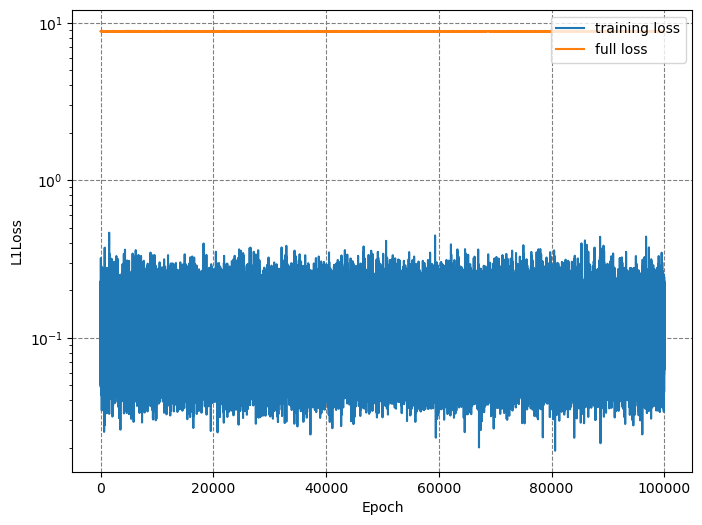

In [14]:
# plot training process
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Epoch")
ax.plot(train_losses, c="C0", label="training loss")
ax.plot(full_losses, c="C1", label="full loss")
ax.set_ylabel(criterion.__class__.__name__)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.set_yscale("log")
ax.grid(color="gray", linestyle="dashed")
fig.savefig(output_dir + file_name + "_losses.png")

In [15]:
# parameter values after training
for name, param in cal_model.named_parameters():
    if param.requires_grad and name.startswith("raw_"):
        print(f"{name[4:]}: ", getattr(cal_model, name[4:]).data)

y_scale:  tensor([4.3734, 3.9757, 0.6931, 0.6931, 0.6931])
y_shift:  tensor([-0.0186, -0.0166,  0.0000,  0.0000,  0.0000])
x_scale:  tensor([0.9180, 0.8705, 0.7381, 1.1926, 0.4858, 0.1704, 0.7801, 0.7675, 0.8184,
        0.7018, 1.3554, 1.0237, 0.4594, 0.8795, 0.8260, 0.5624])
x_shift:  tensor([ 0.3408,  0.6113,  0.2277,  0.0316,  0.6795,  2.5272,  0.3076, -0.7094,
         0.4186, -1.0237, -0.1593,  0.1708,  1.1560, -0.0379,  0.0907,  0.8811])


In [16]:
# calculate calibrated normalized predictions
with torch.no_grad():
    predictions_n_cal = cal_model(x_n)
predictions_n_cal.shape

torch.Size([834, 5])

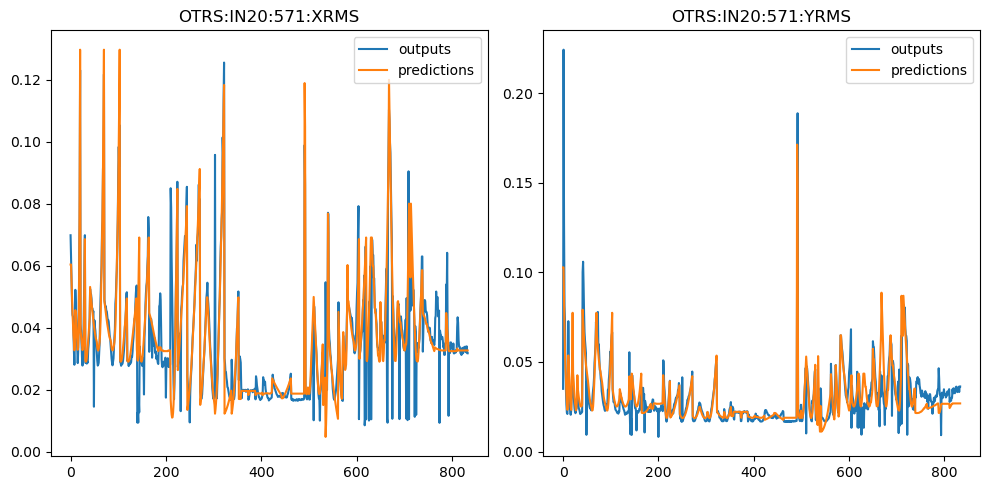

In [17]:
# plot example data and predictions
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for i, output_name in enumerate(lume_module.output_order):
    x_axis = torch.arange(y_n.shape[0])
    ax[i].plot(x_axis, y_n[:, i], "C0-", label="outputs")
    ax[i].plot(x_axis, predictions_n_cal[:, i], "C1-", label="predictions")
    ax[i].legend()
    ax[i].set_title(output_name)
fig.tight_layout()
fig.savefig(output_dir + file_name + "_predictions.png")

### Check 1D Scans

In [18]:
# create LUME-model
cal_lume_model = PyTorchModel(
    model_file=output_dir + file_name + "_model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

In [19]:
# wrap in LUMEModule
cal_lume_module = LUMEModule(
    model=cal_lume_model,
    feature_order=cal_lume_model.features,
    output_order=cal_lume_model.outputs,
)

In [20]:
# define objective models
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)
cal_objective_model = ObjectiveModel(cal_lume_module)

In [21]:
# create reference point
ref_x = []
for key in input_variables.keys():
    if key == "QUAD:IN20:425:BACT":
        center_value = np.mean(input_variables[key].value_range)
        ref_x.append(center_value)
    else:
        ref_x.append(input_variables[key].default)
ref_x = torch.FloatTensor(ref_x)

In [22]:
# define 1D scan sample function
def scan_ref_x(n_samples, name):
    idx = list(input_variables.keys()).index(name)
    v_lim = input_variables[name].value_range
    samples = ref_x.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples)
    return samples.double()

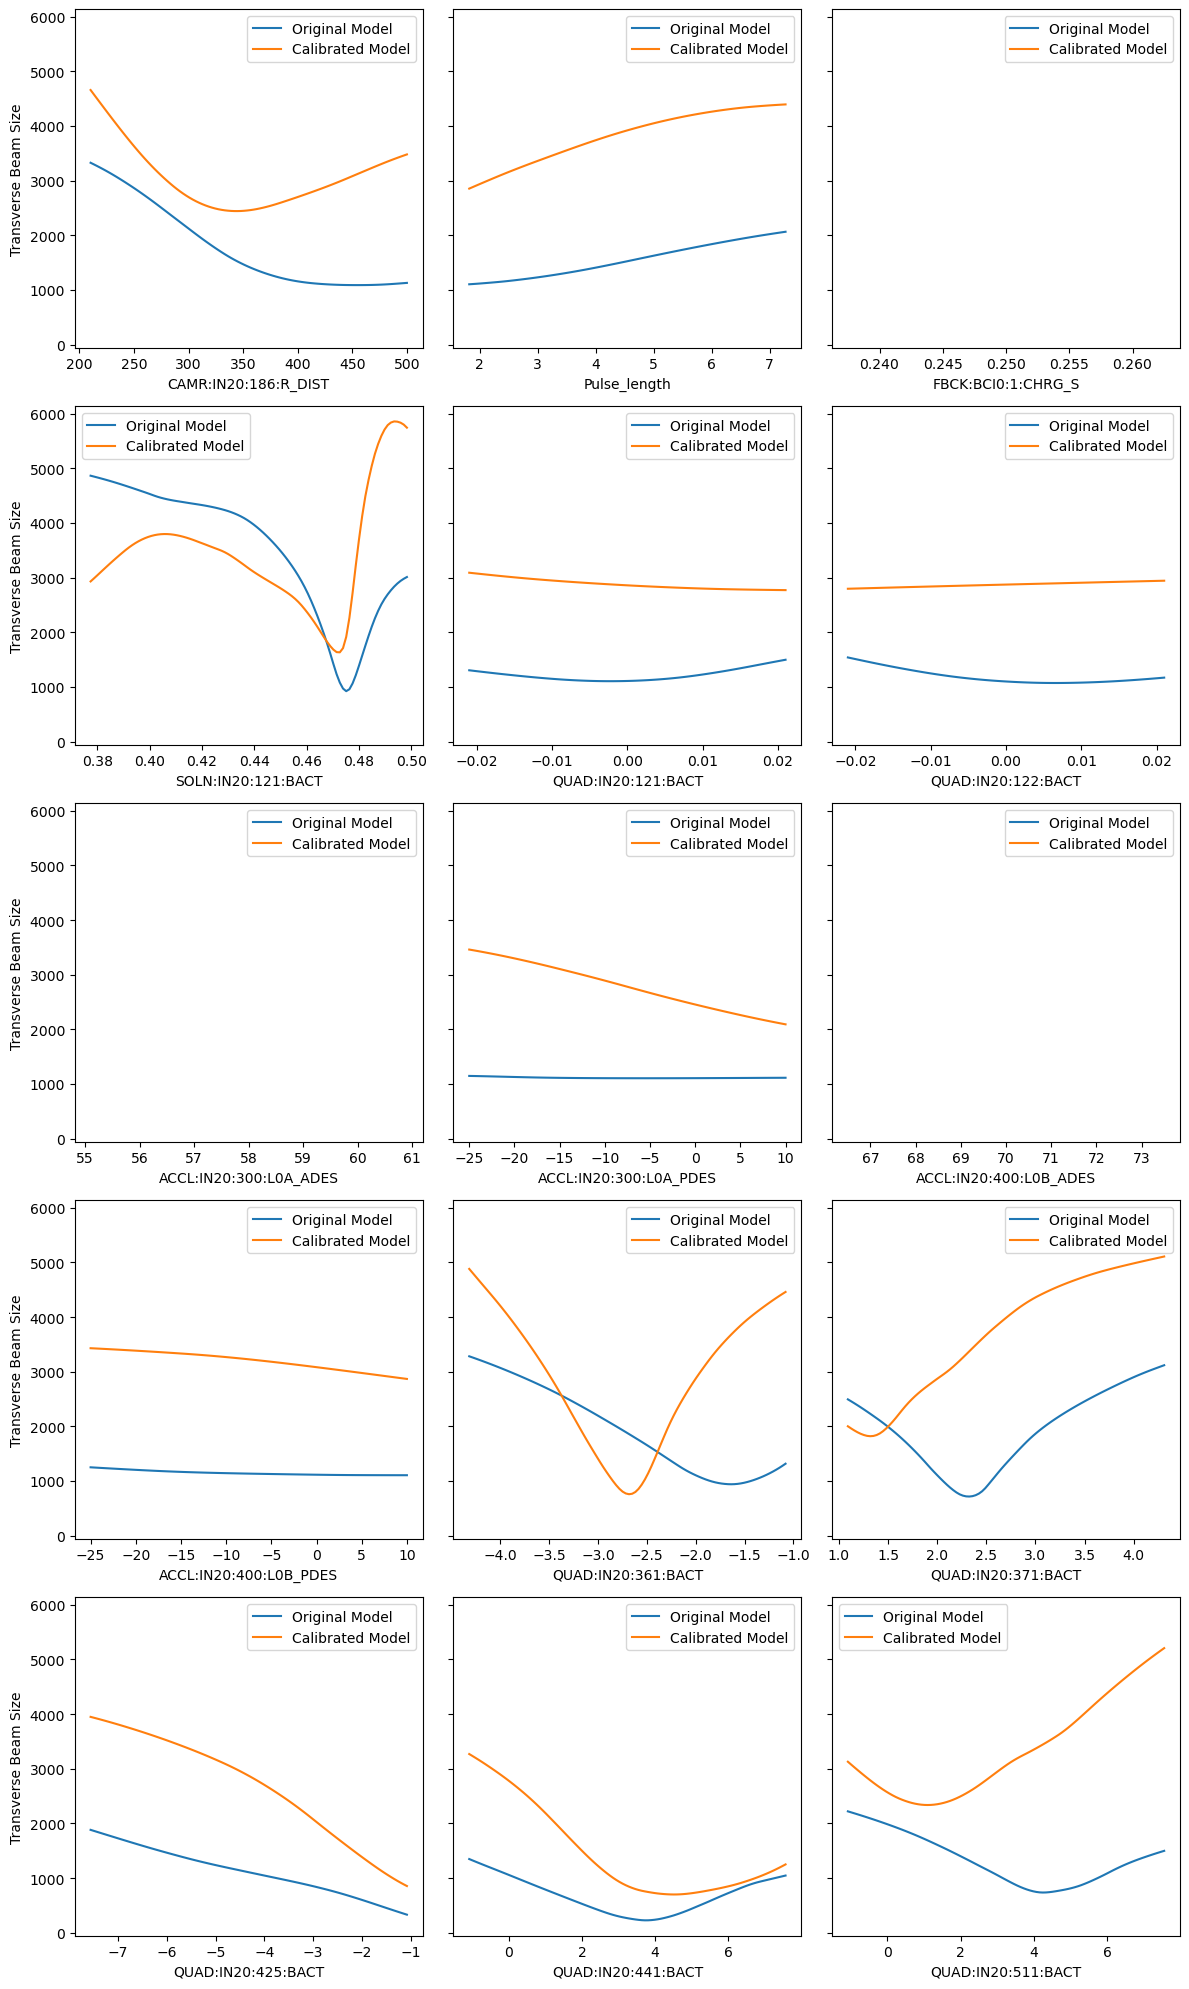

In [23]:
# correlation for individual input dimensions
n_scan = 100
nrows, ncols = 5, 3
figsize = (12, 12 * nrows / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=figsize)
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i >= len(input_variables.keys()):
        ax_i.axis('off')
    else:
        name = list(input_variables.keys())[i]
        # calculate 1D scan
        x_scan = scan_ref_x(n_scan, name=name)
        y_scan = objective_model(x_scan).detach()
        y_scan_cal = cal_objective_model(x_scan).detach()

        # plot data
        idx = list(input_variables.keys()).index(name)
        ax_i.plot(x_scan[:, idx], y_scan, "C0", label="Original Model")
        ax_i.plot(x_scan[:, idx], y_scan_cal, "C1", label="Calibrated Model")
        ax_i.set_xlabel(name)
        if i % ncols == 0:
            ax_i.set_ylabel("Transverse Beam Size")
        ax_i.legend()
fig.tight_layout()
fig.savefig(output_dir + file_name + "_1d_scan.png")